In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tra_df = pd.read_csv("train_dataset_final1.csv")
val_df = pd.read_csv("validate_dataset_final.csv")

In [ ]:

tra_df['age'].fillna(tra_df['age'].median(), inplace=True)

X = tra_df.drop(columns=['Customer_ID', 'next_month_default'])
y = tra_df['next_month_default']

X_val = val_df.drop(columns=['Customer_ID'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val)

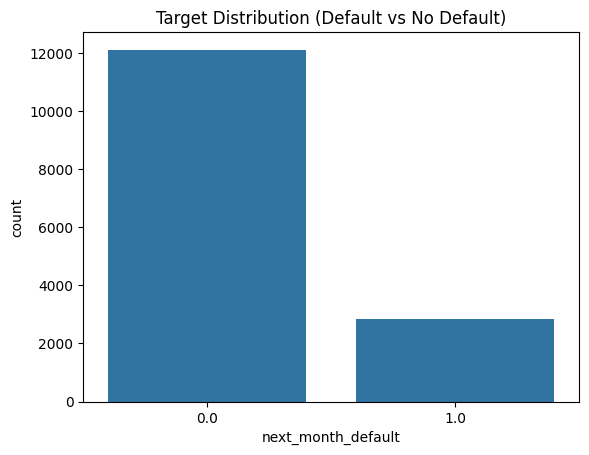

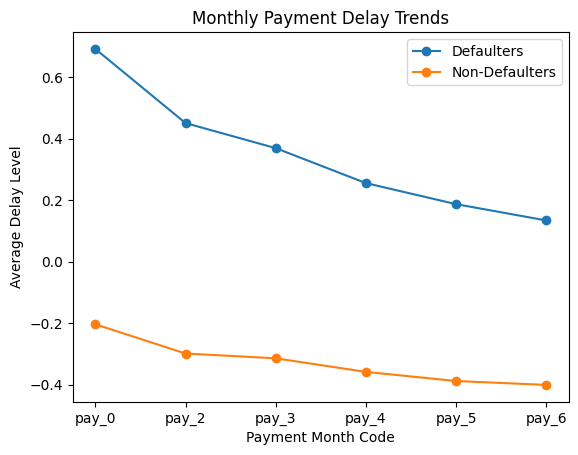

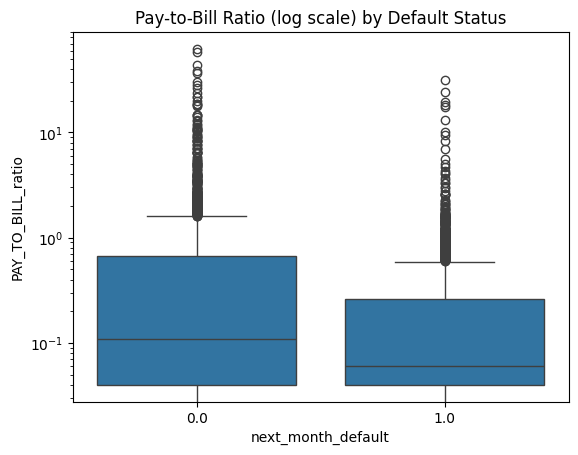

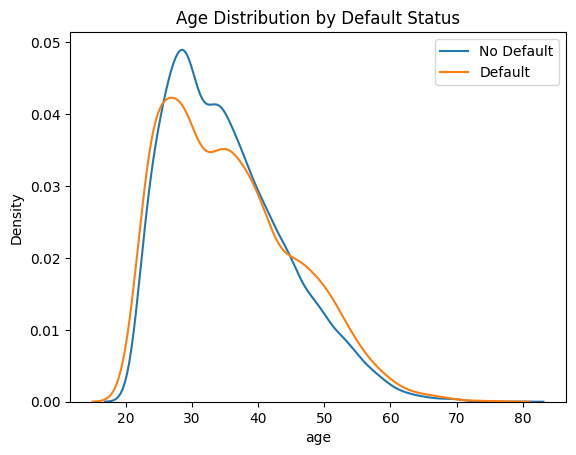

In [ ]:

sns.countplot(x='next_month_default', data=tra_df)
plt.title('Target Distribution (Default vs No Default)')
plt.show()

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
defaulters = tra_df[tra_df['next_month_default'] == 1][pay_cols].mean()
non_defaulters = tra_df[tra_df['next_month_default'] == 0][pay_cols].mean()

plt.plot(pay_cols, defaulters, marker='o', label='Defaulters')
plt.plot(pay_cols, non_defaulters, marker='o', label='Non-Defaulters')
plt.title('Monthly Payment Delay Trends')
plt.xlabel('Payment Month Code')
plt.ylabel('Average Delay Level')
plt.legend()
plt.show()

sns.boxplot(x='next_month_default', y='PAY_TO_BILL_ratio', data=tra_df)
plt.yscale('log')
plt.title('Pay-to-Bill Ratio (log scale) by Default Status')
plt.show()

sns.kdeplot(data=tra_df[tra_df['next_month_default'] == 0], x='age', label='No Default')
sns.kdeplot(data=tra_df[tra_df['next_month_default'] == 1], x='age', label='Default')
plt.title('Age Distribution by Default Status')
plt.legend()
plt.show()


In [ ]:

non_null_indices = y.notnull()
X_scaled = X_scaled[non_null_indices]
y = y[non_null_indices]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_scaled)
    results[name] = {
        'Accuracy': accuracy_score(y, preds),
        'Recall': recall_score(y, preds),
        'F1': f1_score(y, preds),
        'F2': fbeta_score(y, preds, beta=2)
    }
print("\n--- Model Performance Summary on Training Data ---\n")
for name, metrics in results.items():
    print(f"{name}: {metrics}")


best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = models[best_model_name]
print(f"\nSelected Best Model: {best_model_name}\n")

[LightGBM] [Info] Number of positive: 12114, number of negative: 12114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6271
[LightGBM] [Info] Number of data points in the train set: 24228, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Model Performance Summary on Training Data ---

Logistic Regression: {'Accuracy': 0.6859377088624515, 'Recall': 0.6513342696629213, 'F1': 0.44119395885360924, 'F2': 0.5471008081165576}
Random Forest: {'Accuracy': 1.0, 'Recall': 1.0, 'F1': 1.0, 'F2': 1.0}
Gradient Boosting: {'Accuracy': 0.8214810854163882, 'Recall': 0.49683988764044945, 'F1': 0.5144519178331213, 'F2': 0.5037379850480598}
XGBoost: {'Accuracy': 0.9230049458628525, 'Recall': 0.6860955056179775, 'F1': 0.7723320158102767, 'F2'

In [ ]:

preds_val = best_model.predict(X_val_scaled)

submission = pd.DataFrame({
    'Customer': val_df['Customer_ID'],
    'next_month_default': preds_val
})

submission.to_csv('submission_22123043_Amey_Som.csv', index=False)
submission.head()


,Customer,next_month_default
0,1,0.0
1,2,0.0
2,3,0.0
3,4,1.0
4,5,0.0
